# Plotting the likelihood function across boundaries.

In [1]:
import numpy as np
import pandas as pd
import h5py
import emcee

import corner

import stardate as sd
from stardate.lhf import lnprob

from tqdm import trange
import pandas as pd
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
mist = MIST_Isochrone()

Let's start by plotting the rotation period model.

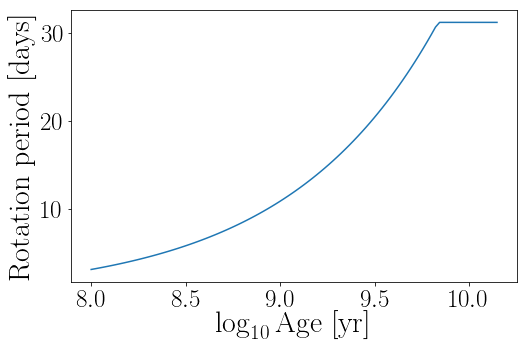

In [7]:
import numpy as np
from stardate.lhf import gyro_model_rossby, convective_overturn_time
import matplotlib.pyplot as plt
%matplotlib inline

plotpar = {'axes.labelsize': 30,
           'font.size': 25,
           'legend.fontsize': 15,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

N = 100
ages = np.linspace(8, np.log10(14*1e9), N)
periods = np.empty(N)
for i, age in enumerate(ages):
    periods[i] = gyro_model_rossby(age, .65, 1.)

plt.figure(figsize=(8, 5))
plt.plot(ages, periods)
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.xlabel("$\log_{10}\mathrm{Age~[yr]}$");

In [9]:
def set_params(eep, age, feh):
    """
    Calculate B-V, mass and rotation period from EEP, age and feh.
    """
    logg = mist.logg(eep, age, feh)
    teff = mist.Teff(eep, age, feh)
    iso_params = pd.DataFrame(dict({"teff": (teff, 10),
                                    "logg": (logg, .05),
                                    "feh": (0., .001),
                                    "parallax": (1., .01)}))  # mas
    mag_pars = [eep, age, feh, 1000., 0.]
    bv = mist.mag["B"](*mag_pars) - mist.mag["V"](*mag_pars)
    prot = gyro_model_rossby(age, bv, mist.mass(eep, age, feh))
    return mist.mass(eep, age, feh), bv, prot, iso_params

Now let's set up a fake star with some true parameters.

In [69]:
# true_eep, true_age, true_feh = 405, np.log10(2.295*1e9), 0.
true_eep, true_age, true_feh = 360, np.log10(4.5*1e9), 0.

mass, bv, prot, iso_params = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., None, None, False, False]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print("rossby = ", prot/convective_overturn_time(true_eep, true_age, true_feh))

mass =  1.0187201234928676
B-V =  0.5927202678297903
prot =  22.346907227352045
rossby =  1.5894769735944863


Next we'll map out the lnprobability space over a range of EEPs, fehs and ages.

/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/mist/grid.py:193: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = super(MISTModelGrid, self).df_all(phot)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['[Fe/H]']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [84]:
N = 20
eep_array = np.linspace(250, 490, N)
age_array = np.linspace(8, 10, N)
feh_array = np.linspace(-.2, .2, N)
bv_array, prot_array, mass_array, probs_array = [np.empty(N) for i in range(4)]

eeps, ages, fehs = np.meshgrid(eep_array, age_array, feh_array, indexing="ij")
bvs, masses, prots, probs, priors = [np.empty((N, N, N)) for i in range(5)]

for i in trange(N):
    for j in range(N):
        for k in range(N):
            _mass, _bv, _prot, _ = set_params(eeps[i, j, k], ages[i, j, k], fehs[i, k, j])
            bvs[i, j, k], prots[i, j, k], masses[i, j, k] = _bv, _prot, _mass
            
            # Evolved stars
            if eeps[i, j, k] > 454:
                prots[i, j, k] += np.random.randn(1)*10
            
            # Hot stars and late Ms
            if bvs[i, j, k] < .45 or bvs[i, j, k] > 1.25:
                prots[i, j, k] = 10**(np.random.randn(1)*.55 + .5)
            
            lnparams = [eeps[i, j, k], ages[i, j, k], fehs[i, j, k], np.log(1000.), 0.]
            args = [mod, prots[i, j, k], 1., None, None, False, False]
            prob, prior = lnprob(lnparams, *args)
            probs[i, j, k] = prob
            priors[i, j, k] = prior

  0%|          | 0/20 [00:00<?, ?it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.2rc0-py3.5.egg/stardate/lhf.py:116: RuntimeWarning: invalid value encountered in double_scalars
  age_thresh_myr = (pmax/(a*(bv-c)**b))**(1./n)
100%|██████████| 20/20 [00:07<00:00,  2.45it/s]


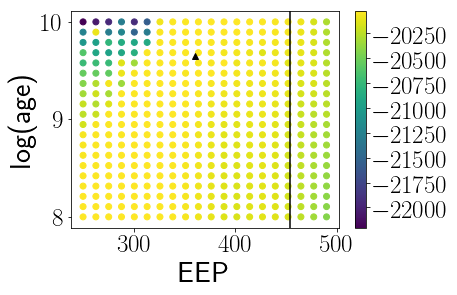

In [85]:
plt.scatter(eeps[:, :, 0], ages[:, :, 0], c=probs[:, :, 0])
plt.plot(true_eep, true_age, "k^")
plt.axvline(454, color="k")
plt.xlabel("EEP")
plt.ylabel("log(age)")
plt.colorbar()

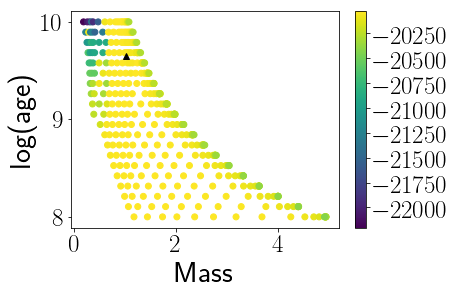

In [86]:
plt.scatter(masses[:, :, 0], ages[:, :, 0], c=probs[:, :, 0])
plt.plot(mass, true_age, "k^")
plt.xlabel("Mass")
plt.ylabel("log(age)")
plt.colorbar()

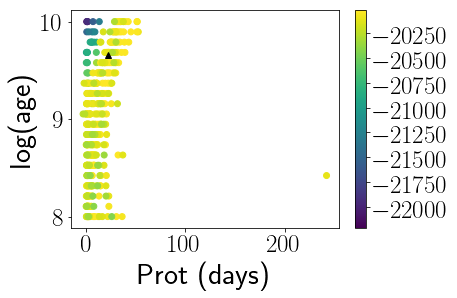

In [87]:
plt.scatter(prots[:, :, 0], ages[:, :, 0], c=probs[:, :, 0])
plt.plot(prot, true_age, "k^")
plt.xlabel("Prot (days)")
plt.ylabel("log(age)")
plt.colorbar()

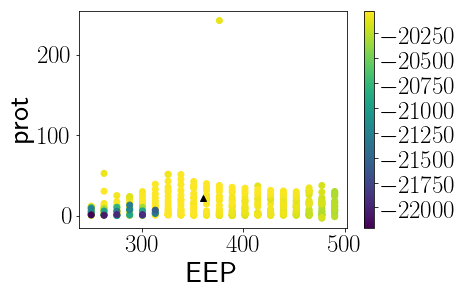

In [88]:
plt.scatter(eeps[:, :, 0], prots[:, :, 0], c=probs[:, :, 0])
plt.plot(true_eep, prot, "k^")
plt.xlabel("EEP")
plt.ylabel("prot")
plt.colorbar()

In [89]:
# plt.plot(eeps[:, 0, 0], probs[:, 0, 0])
# plt.axvline(true_eep, color="C1")
# plt.axvline(454, color="C2")

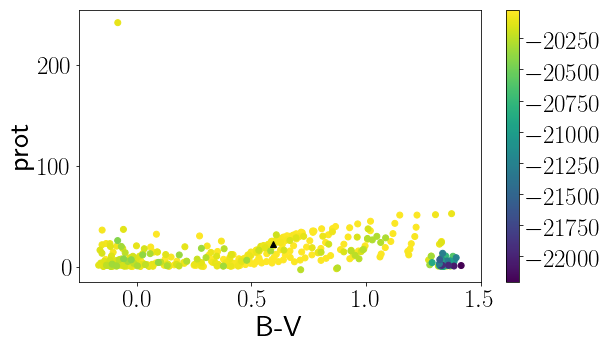

In [90]:
plt.figure(figsize=(9, 5))
plt.scatter(bvs[:, :, 0], prots[:, :, 0], c=probs[:, :, 0])
plt.plot(bv, prot, "k^")
plt.xlabel("B-V")
plt.ylabel("prot")
plt.colorbar()

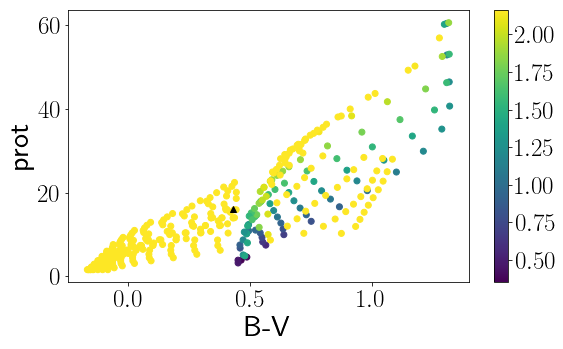

In [60]:
from stardate.lhf import convective_overturn_time
Ro = prots/convective_overturn_time(masses)

plt.figure(figsize=(9, 5))
plt.scatter(bvs[:, :, 0], prots[:, :, 0], c=Ro[:, :, 0])
plt.plot(bv, prot, "k^")
plt.xlabel("B-V")
plt.ylabel("prot")
plt.colorbar()

In [225]:
true_eep, true_age, true_feh = 450, np.log10(3*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False, True]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print("rossby = ", prot/convective_turnover_time(true_eep, true_age, true_feh))
# print(prob)

mass =  1.3894404771515674
B-V =  0.46942811626649394
prot =  9.635853677196272
rossby =  1.1161934562119435


In [226]:
N = 100
eeps = np.linspace(440, 460, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 750.60it/s]


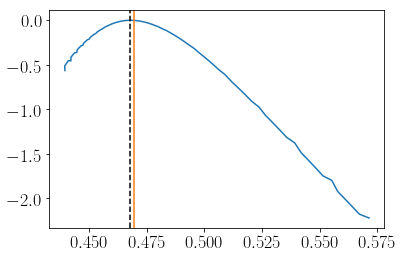

In [227]:
plt.plot(bvs, iso_probs)
plt.axvline(bv, color="tab:orange")
plt.axvline(bvs[iso_probs == max(iso_probs)], color="k", ls="--")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

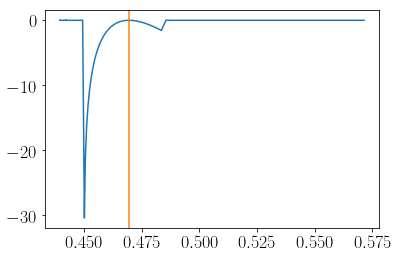

In [228]:
plt.plot(bvs, gyro_probs)
plt.axvline(bv, color="tab:orange")
plt.axvline(bvs[gyro_probs == max(gyro_probs[gyro_probs<0])], color="k", ls="--")
# print(gyro_probs)

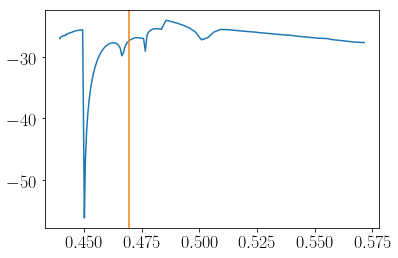

In [229]:
plt.plot(bvs, probs)
plt.axvline(bv, color="tab:orange")

Now look at giants.

In [1000]:
true_eep, true_age, true_feh = 450, np.log10(4*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False, True]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print("rossby = ", prot/convective_turnover_time(true_eep, true_age, true_feh))
print(prob)

mass =  1.2742894399687188
B-V =  0.5174999221524725
prot =  16.606457595890287
rossby =  1.6715154137562216
(-25.227598646350742, -2.465190328815662e-28, -0.0, -25.227598646350742)


In [1001]:
N = 100
eeps = np.linspace(440, 460, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 641.08it/s]


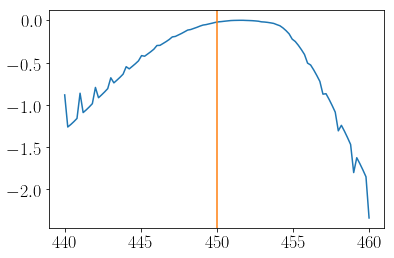

In [1002]:
plt.plot(eeps, iso_probs)
plt.axvline(true_eep, color="tab:orange")

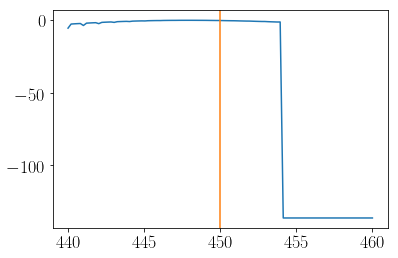

In [1003]:
plt.plot(eeps, gyro_probs)
plt.axvline(true_eep, color="tab:orange")

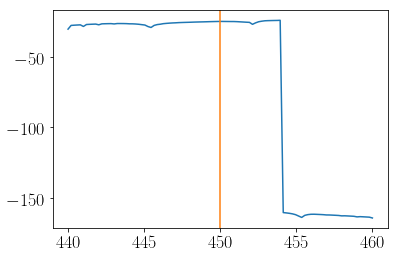

In [1004]:
plt.plot(eeps, probs)
plt.axvline(true_eep, color="tab:orange")

In [1005]:
true_eep, true_age, true_feh = 458, np.log10(4*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False, True]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print("rossby = ", prot/convective_turnover_time(true_eep, true_age, true_feh))
print(prob)

mass =  1.2882046297409566
B-V =  0.5892736204273774
prot =  20.78702482864032
rossby =  2.1291289772100703
(-25.227598646350742, -2.465190328815662e-28, -0.0, -25.227598646350742)


In [1006]:
N = 100
eeps = np.linspace(440, 460, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 687.25it/s]


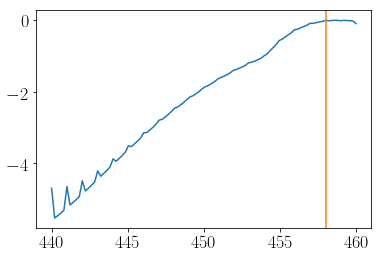

In [1007]:
plt.plot(eeps, iso_probs)
plt.axvline(true_eep, color="tab:orange")

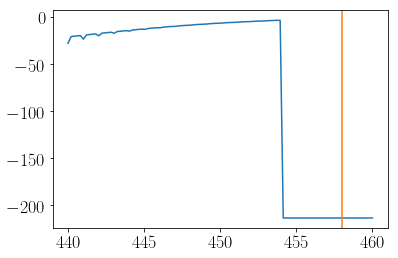

In [1008]:
plt.plot(eeps, gyro_probs)
plt.axvline(true_eep, color="tab:orange")

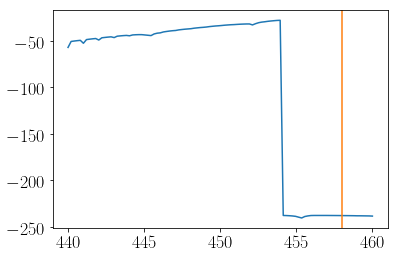

In [1009]:
plt.plot(eeps, probs)
plt.axvline(true_eep, color="tab:orange")

A star past the rossby threshold

In [1010]:
true_eep, true_age, true_feh = 420, np.log10(5.5*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False, True]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print("rossby = ", prot/convective_turnover_time(true_eep, true_age, true_feh))
print(prob)

mass =  1.1172675385790234
B-V =  0.5315589406153691
prot =  20.98049155437155
rossby =  1.7172051415350682
(-25.227598646350742, -2.465190328815662e-28, -0.0, -25.227598646350742)


In [1011]:
N = 100
eeps = np.linspace(300, 400, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 667.75it/s]


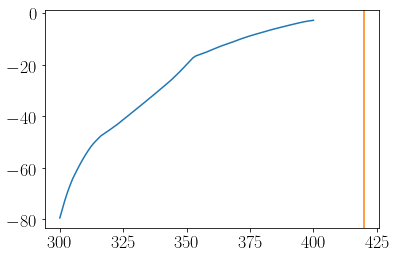

In [1012]:
plt.plot(eeps, iso_probs)
plt.axvline(true_eep, color="tab:orange")

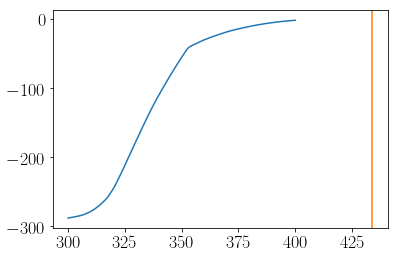

In [894]:
plt.plot(eeps, gyro_probs)
plt.axvline(true_eep, color="tab:orange")

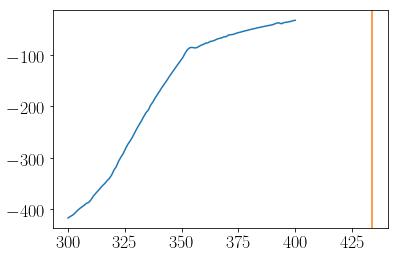

In [895]:
plt.plot(eeps, probs)
plt.axvline(true_eep, color="tab:orange")

In [530]:
N = 100000
ages = np.random.uniform(5., np.log10(13.8*1e9), N)
eeps = np.random.uniform(198, 490, N)
fehs = np.random.randn(N)*.2
distances = np.random.uniform(10., 1000., N)
avs = np.random.uniform(0., .2, N)

Find all the places where this combination produces B-V = .45

In [428]:
bv_map, teffs, loggs, prots = [np.zeros(N) for i in range(4)]
for i in range(N):
    mag_pars = [eeps[i], ages[i], fehs[i], distances[i], avs[i]]
    bv_map[i] = mist.mag["B"](*mag_pars) - mist.mag["V"](*mag_pars)
    prots[i] = gyro_model(ages[i], bv_map[i])
    teffs[i] = mist.Teff(eeps[i], ages[i], fehs[i])
    loggs[i] = mist.logg(eeps[i], ages[i], fehs[i])

/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:43: RuntimeWarning: invalid value encountered in log10
  log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


(5.5, 2.5)

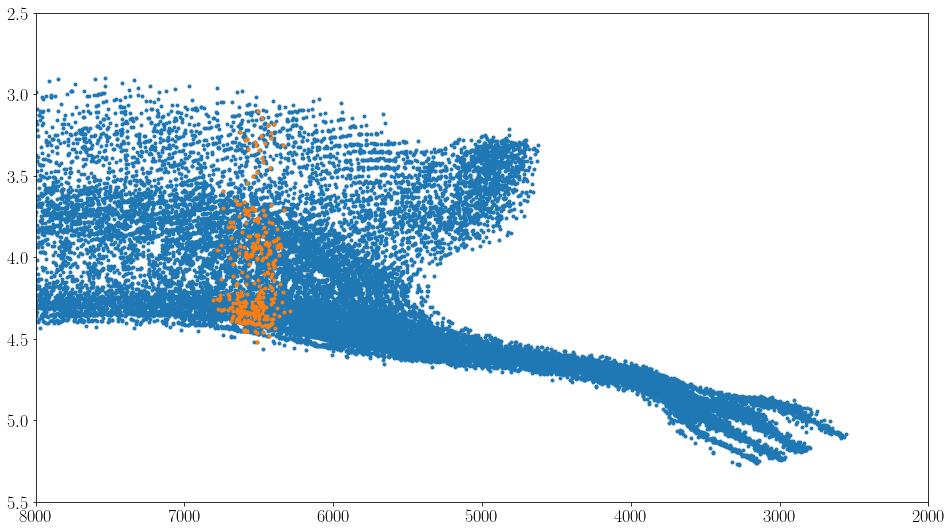

In [429]:
plt.figure(figsize=(16, 9))
# plt.scatter(teffs, loggs, c=bv_map)
# plt.colorbar()
plt.plot(teffs, loggs, ".")
bv_mask = (.45 < bv_map) * (bv_map < .46)
plt.plot(teffs[bv_mask], loggs[bv_mask], ".", color="tab:orange")
plt.xlim(8000, 2000)
plt.ylim(5.5, 2.5)

I could calculate gyro_lnprob for stars with a range of parameters and rotation periods at the border. And find the minimum lnprob. I would compute a lnprob for the orange stars over a range of rotation periods. Then I could look up the nearest star in the catalog and assign a lnprob based 

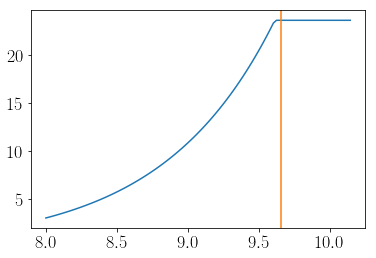

In [636]:
ages = np.linspace(8, np.log10(14*1e9), 100)
mass = 1.2
periods = []
for age in ages:
    periods.append(gyro_model_rossby(mass, age, .65))
plt.plot(ages, periods)
plt.axvline(np.log10(4.56*1e9), color="tab:orange")

In [582]:
pmax, bv = 25, .65
a, b, c, n = [.4, .31, .45, .55]
(pmax/(a*(bv-c)**b))**(1./n)

4562.483498355086

In [583]:
pmax = 2.16 * convective_turnover_time(mass)

Find the B-V that corresponds to bp-rp = 2.4

In [737]:
df = pd.read_csv("data/praesepe.csv")
m = (2.38 < df.bp.values - df.rp.values) * (df.bp.values - df.rp.values < 2.41)
for i in range(sum(m)):
    print(df.bp.values[m][i], df.rp.values[m][i], df.parallax.values[m][i], 
          df.parallax_err.values[m][i], df.bp.values[m][i] - df.rp.values[m][i])

16.90842 14.523178 5.468079785987519 0.08370221098483661 2.385242
16.835106 14.427689 5.194170450880093 0.2518898423029565 2.407416999999999
16.948387 14.546851 5.279415275413722 0.06128636587163337 2.401536
16.870617000000003 14.469619 5.576882243267776 0.07028991516732537 2.400998000000003


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [740]:
iso_params = pd.DataFrame(dict({"bp": (16.90842, .001),
                                "rp": (14.523178, .001), 
                                "parallax": (5.468079785987519, .08)}))
model = StarModel(mist, *iso_params)
model.fit()
# mag_pars = [eep, age, feh, 1000., 0.]
# bv = mist.mag["B"](*mag_pars) - mist.mag["V"](*mag_pars)

FileNotFoundError: File b'bp' does not exist